In [1]:
import pyro
import pyro.distributions as distro 
import torch
import seaborn as sns
from math import sqrt, exp as sqrt, exp
import matplotlib.pyplot as plt
from pyro.infer.mcmc import NUTS, MCMC
import numpy as np

## Exercise 1

In [2]:
normal = lambda loc, scale: distro.Normal(loc, scale)

### 1.1

In [3]:
def gibbs_sampler(rho, mu1, mu2, sigma1, sigma2, warmup=1000, iters=1000):

    # starting value for x_2
    # x2 = pyro.sample('starting_point', normal(mu2, sigma2))
    x2 = 0

    # samples containers
    x1_samples = []
    x2_samples = []

    for i in range(warmup + iters):

        loc1 = mu1 + (rho/sigma2**2)*(x2 - mu2)
        scale1 = sigma1**2 - (rho/sigma2)**2
        x1 = pyro.sample('x1', normal(loc1, scale1))

        loc2 = mu2 + (rho/sigma1**2)*(x1 - mu1)
        scale2 = sigma2**2 - (rho/sigma1)**2
        x2 = pyro.sample('x2', normal(loc2, scale2))
        
        if i >= warmup: 
            x1_samples.append(x1)
            x2_samples.append(x2)

    return x1_samples, x2_samples

### 1.2

In [4]:
# define hyperparamters
rho = 0.3; mu1 = 0.5; mu2 = 0.1; sigma1 = 1; sigma2 = 1.5

/home/macro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/macro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


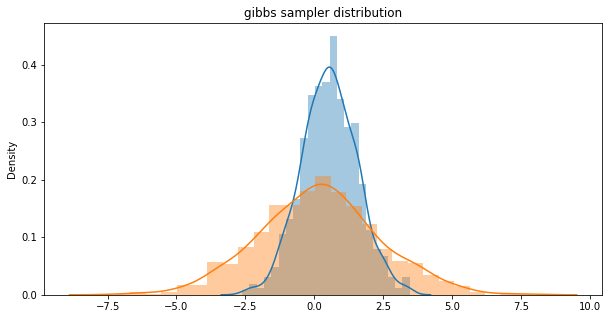

In [5]:
x1, x2 = gibbs_sampler(rho, mu1, mu2, sigma1, sigma2)

# plotting
fig, axes = plt.subplots(1, figsize = (10,5))
sns.distplot(x1, ax = axes)
sns.distplot(x2, ax = axes)
axes.set_title('gibbs sampler distribution')
plt.show()

## Exercise 2

### 2.1

In [6]:
# define parameters
theta1 = 0.5
theta2 = 3


In [7]:
# define function of section 1 of exercise 2
def f(x, t1, t2): 
    return (torch.exp(t1*x) + t2)/x

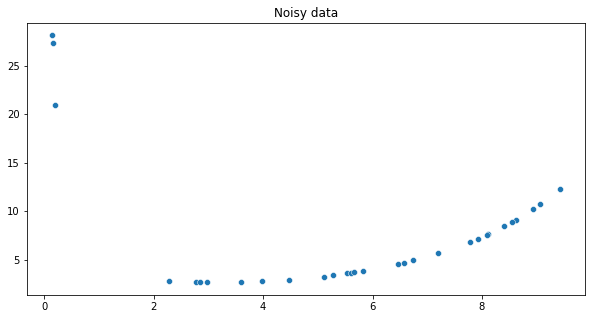

In [8]:
# noisy data generation
def obs(theta1, theta2, n_obs = 30):
    rho = pyro.sample('rho', normal(0, 0.3))
    with pyro.plate('observations', n_obs):
        x_obs = pyro.sample('x_obs', distro.Uniform(0,10))
        y_obs = f(x_obs, theta1, theta2) + rho
    return x_obs, y_obs

x_obs, y_obs = obs(theta1, theta2)

# plotting
fig, axes = plt.subplots(1, figsize = (10,5))
sns.scatterplot(x = x_obs, y = y_obs, ax = axes)
axes.set_title('Noisy data')
plt.show()

### 2.2

In [9]:
# implement generative model
def generative_model(x_obs):

    par1 = pyro.sample('theta1', distro.Exponential(2.))
    par2 = pyro.sample('theta2', distro.Exponential(0.2))
    gamma = pyro.sample('gamma', distro.Uniform(0,0.5))

    y_hat = f(x_obs, par1, par2)

    y = pyro.sample('y', distro.Normal(y_hat, gamma))
    
    return y

conditioned_model = pyro.condition(generative_model, data = {'y': y_obs})

In [10]:
kernel = NUTS(conditioned_model, jit_compile = True, ignore_jit_warnings = True)
mcmc = MCMC(kernel, warmup_steps = 2000, num_samples = 100, num_chains = 4)
mcmc.run(x_obs)

Warmup [1]:   0%|          | 0/2100 [00:00, ?it/s]






Warmup [1]:   0%|          | 1/2100 [00:01,  1.14s/it, step size=3.43e-06, acc. prob=1.000]

Warmup [1]:   0%|          | 7/2100 [00:01,  7.33it/s, step size=8.28e-06, acc. prob=0.857]


Warmup [1]:   1%|          | 11/2100 [00:01, 11.00it/s, step size=1.06e-04, acc. prob=0.909]


Warmup [1]:   1%|          | 14/2100 [00:01, 13.89it/s, step size=6.53e-04, acc. prob=0.929]


Warmup [1]:   1%|          | 18/2100 [00:01, 17.63it/s, step size=6.30e-03, acc. prob=0.944]


Warmup [1]:   1%|          | 23/2100 [00:01, 23.04it/s, step size=4.41e-03, acc. prob=0.913]

Warmup [1]:   2%|▏         | 32/2100 [00:01, 35.24it/s, step size=1.47e-03, acc. prob=0.875]


Warmup [1]:   2%|▏         | 37/2100 [00:02, 32.20it/s, step size=1.14e-03, acc. prob=0.864]



Warmup [1]:   2%|▏         | 41/2100 [00:02, 28.55it/s, step size=3.68e-03, acc. prob=0.871]


Warmup [1]:   2%|▏         | 46/2100 [00:02, 30.39it/s, step size=2.64e-03, acc. prob=0.863

In [11]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     gamma      0.10      0.01      0.10      0.08      0.12    178.97      0.99
    theta1      0.50      0.00      0.50      0.50      0.50    479.02      1.00
    theta2      3.03      0.01      3.03      3.01      3.04    119.52      1.04

Number of divergences: 0


In [13]:
posterior = mcmc.get_samples()

In [24]:
mcmc.get_samples().keys()

dict_keys(['gamma', 'theta1', 'theta2'])

### 2.3

/home/macro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/macro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/macro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

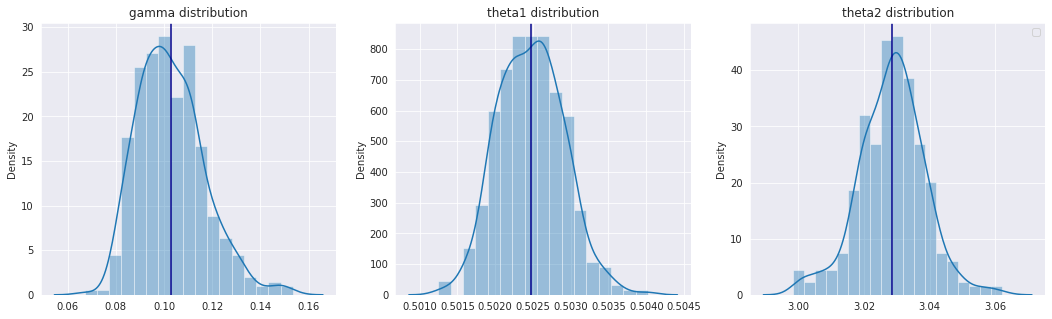

In [30]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(1, 3, figsize = (18,5))

estimates = []
i = 0
for i, par in enumerate(posterior.keys()):
    trace = posterior[par]
    sns.distplot(trace, ax = ax[i])
    ax[i].axvline(trace.mean(), color = 'darkblue')
    ax[i].set_title('{} distribution'.format(par))
    estimates.append(trace.mean())
plt.legend()
plt.show()

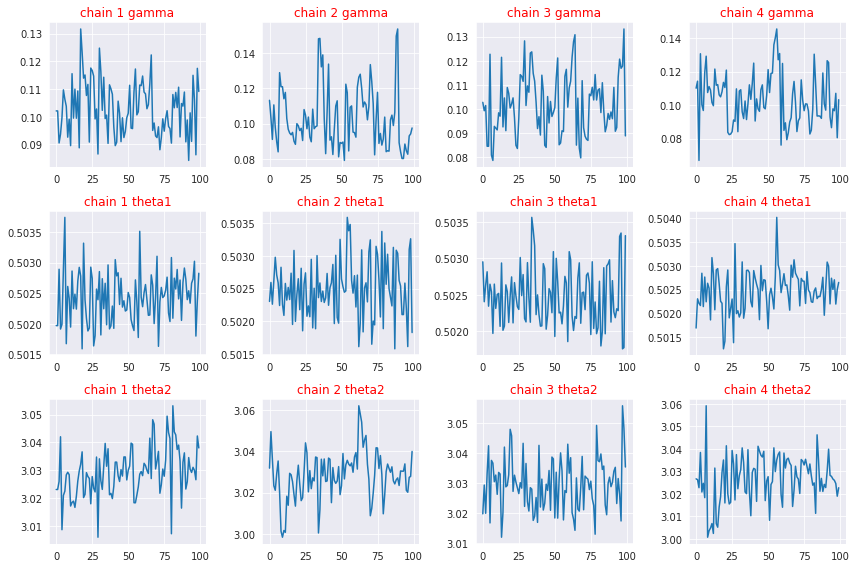

In [23]:
def plot_chains(mcmc):

    mcmc_samples = mcmc.get_samples(group_by_chain = True)

    n_chains, n_samples = mcmc.num_chains, mcmc.num_samples

    fig, ax = plt.subplots(3, n_chains, figsize = (12,8))

    for j, par in enumerate(mcmc_samples.keys()):
        for i, chain in enumerate(mcmc_samples[par]):
            sns.lineplot(x = range(n_samples), y = chain, ax = ax[j][i])
            ax[j][i].set_title('chain {} {}'.format(i+1, par), color = 'red')
            plt.tight_layout()

plot_chains(mcmc)

### 2.4

<AxesSubplot:>

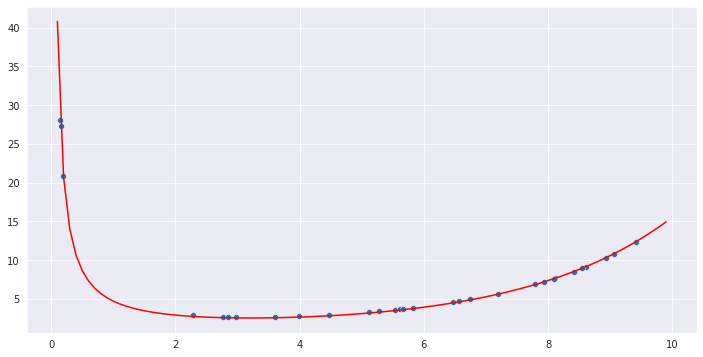

In [33]:
fig, ax = plt.subplots(1, figsize = (12,6))

sns.scatterplot(x = x_obs, y = y_obs, ax = ax)
x = torch.arange(0,10,0.1)
sns.lineplot(x = x, y = f(x, estimates[1], estimates[2]), ax = ax, color = 'red')

